## Introduction to LogView

**LogView** is a lightweight framework built on top of **PM4Py** to support **exploratory case filtering** and **comparative process analysis**, introduced in the following publication:

> **Zerbato, F., Franceschetti, M., & Weber, B. (2024)**  
> *A Framework to Support the Validation of Process Mining Inquiries*.  
> In: *Business Process Management Forum: BPM 2024 Forum, Krakow, Poland, September 1–6, 2024, Proceedings*. Lecture Notes in Business Information Processing (LNBIP), Vol. 526, Springer, pp. 249–266.

It provides an interface for interactively applying and tracking **filtering queries** on event logs, enabling reproducible, explainable filtering steps that analysts can later compare, visualize, and explain.

### Query-Based Filtering

At the heart of LogView is the `Query` object, which is a wrapper around case-level filters (predicates) that apply conditions on log attributes or behavior.

For example:

```python
Query("HighValue", [GreaterThanConstant("RequestedAmount", 10000)])


Each query is evaluated using:
```python
result_set, complement_set = log_view.evaluate_query("rs_HighValue", log, query)

### Query Registry

Every time you run a query in LogView, the framework stores its full context in a central **Query Registry**. This registry acts like a logbook of your filtering steps and supports full traceability of how result sets are derived.
This enables full **lineage tracking**. Each result set can be traced back to its original source through a series of clearly defined filters.

You can view this lineage at any time:
```python
summary = log_view.get_summary()

### Icicle Chart — `icicle(...)`

Use this to **trace the entire filter sequence** and see how each filter affects the dataset.

#### What it shows:
- How each query splits the data (✓ passed vs ✗ failed)
- Case counts at each stage
- Average values for a selected metric (e.g. duration or event count)
- 🟡 Highlights the **main path** that led to your final result set

#### Call it like this:

```python
icicle('rs_HighValue', log_view, metric='avg_case_duration_seconds')
metric options: 'avg_case_duration_seconds', 'avg_events_per_case', 'avg_time_between_events'

### Pie Chart — `pie(...)`

Use the **pie chart** to **zoom in on the last filter step** and compare how cases diverge based on their **entire filter history**.

#### What it shows:
- Each slice represents a group of cases that evaluates True to the last filter
- Size = number of cases
- Color = average value of a selected metric
- 🟡 = the filtered result set you're analyzing

#### Call it like this:
```python
pie('rs_Successful', log_view, metric='avg_case_duration_seconds')
metric options: 'avg_case_duration_seconds', 'avg_events_per_case', 'avg_time_between_events'

### Imports & Setup

Import all necessary libraries and custom functions:

In [18]:
%pip install -r requirements.txt

import os
import sys
import zipfile
import pandas as pd
import pm4py
from logview.utils import LogViewBuilder
from logview.predicate import *
from filter_visualization import icicle, pie
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualizer

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
# Load LogView

if not os.path.exists("logview"):
    !git clone https://github.com/fzerbato/logview.git
    print("Cloned logview.")
else:
    print("logview already cloned.")

logview_path = os.path.abspath("logview")

if logview_path not in sys.path:
    sys.path.append(logview_path)
    print(f"Added to sys.path: {logview_path}")

%pip install -r logview/requirements.txt

Cloned logview.
Added to sys.path: c:\Users\cshek\OneDrive\Bureaublad\Master-Thesis-Experiment\logview


Cloning into 'logview'...


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


### Load and Prepare Event Log

Then load your event log and format it for analysis with PM4Py. The code below does this for the BPI Challenge 2017 dataset:


In [3]:
# Load data

csv_file = "BPI_Challenge_2017.csv"
zip_file = "BPI_Challenge_2017.zip"

if not os.path.exists(csv_file):
    if os.path.exists(zip_file):
        print(f"Extracting {csv_file} from {zip_file}...")
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extract(csv_file)
    else:
        raise FileNotFoundError(f"Both '{csv_file}' and '{zip_file}' not found")
    
CASE_ID_COL = 'case'
TIMESTAMP_COL = 'time'
ACTIVITY_COL = 'event'
    
bpi_data = pd.read_csv(csv_file, sep=',', quotechar='"')
bpi_data.columns = bpi_data.columns.str.strip()
bpi_data[TIMESTAMP_COL] = pd.to_datetime(bpi_data[TIMESTAMP_COL], format='%Y/%m/%d %H:%M:%S.%f')
log = pm4py.format_dataframe(bpi_data, case_id=CASE_ID_COL, activity_key=ACTIVITY_COL, timestamp_key=TIMESTAMP_COL)

display(log)

,case,event,time,lifecycle:transition,ApplicationType,LoanGoal,RequestedAmount,MonthlyCost,org:resource,Selected,...,Accepted,CreditScore,NumberOfTerms,EventOrigin,OfferedAmount,case:concept:name,concept:name,time:timestamp,@@index,@@case_index
0,Application_1000086665,A_Create Application,2016-08-03 17:57:21.673000+00:00,COMPLETE,New credit,"Other, see explanation",5000.0,NaN,User_1,NaN,...,NaN,NaN,NaN,Application,NaN,Application_1000086665,A_Create Application,2016-08-03 17:57:21.673000+00:00,0,0
1,Application_1000086665,A_Submitted,2016-08-03 17:57:21.734000+00:00,COMPLETE,New credit,"Other, see explanation",5000.0,NaN,User_1,NaN,...,NaN,NaN,NaN,Application,NaN,Application_1000086665,A_Submitted,2016-08-03 17:57:21.734000+00:00,1,0
2,Application_1000086665,W_Handle leads,2016-08-03 17:57:21.963000+00:00,SCHEDULE,New credit,"Other, see explanation",5000.0,NaN,User_1,NaN,...,NaN,NaN,NaN,Workflow,NaN,Application_1000086665,W_Handle leads,2016-08-03 17:57:21.963000+00:00,2,0
3,Application_1000086665,W_Handle leads,2016-08-03 17:58:28.286000+00:00,WITHDRAW,New credit,"Other, see explanation",5000.0,NaN,User_1,NaN,...,NaN,NaN,NaN,Workflow,NaN,Application_1000086665,W_Handle leads,2016-08-03 17:58:28.286000+00:00,3,0
4,Application_1000086665,W_Complete application,2016-08-03 17:58:28.293000+00:00,SCHEDULE,New credit,"Other, see explanation",5000.0,NaN,User_1,NaN,...,NaN,NaN,NaN,Workflow,NaN,Application_1000086665,W_Complete application,2016-08-03 17:58:28.293000+00:00,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202262,Application_999993812,W_Call incomplete files,2016-10-20 10:19:28.812000+00:00,RESUME,New credit,Caravan / Camper,30000.0,NaN,User_41,NaN,...,NaN,NaN,NaN,Workflow,NaN,Application_999993812,W_Call incomplete files,2016-10-20 10:19:28.812000+00:00,1202262,31508
1202263,Application_999993812,W_Call incomplete files,2016-10-20 10:21:59.667000+00:00,SUSPEND,New credit,Caravan / Camper,30000.0,NaN,User_41,NaN,...,NaN,NaN,NaN,Workflow,NaN,Application_999993812,W_Call incomplete files,2016-10-20 10:21:59.667000+00:00,1202263,31508
1202264,Application_999993812,O_Accepted,2016-10-24 08:24:30.056000+00:00,COMPLETE,New credit,Caravan / Camper,30000.0,NaN,User_68,NaN,...,NaN,NaN,NaN,Offer,NaN,Application_999993812,O_Accepted,2016-10-24 08:24:30.056000+00:00,1202264,31508
1202265,Application_999993812,A_Pending,2016-10-24 08:24:30.059000+00:00,COMPLETE,New credit,Caravan / Camper,30000.0,NaN,User_68,NaN,...,NaN,NaN,NaN,Application,NaN,Application_999993812,A_Pending,2016-10-24 08:24:30.059000+00:00,1202265,31508


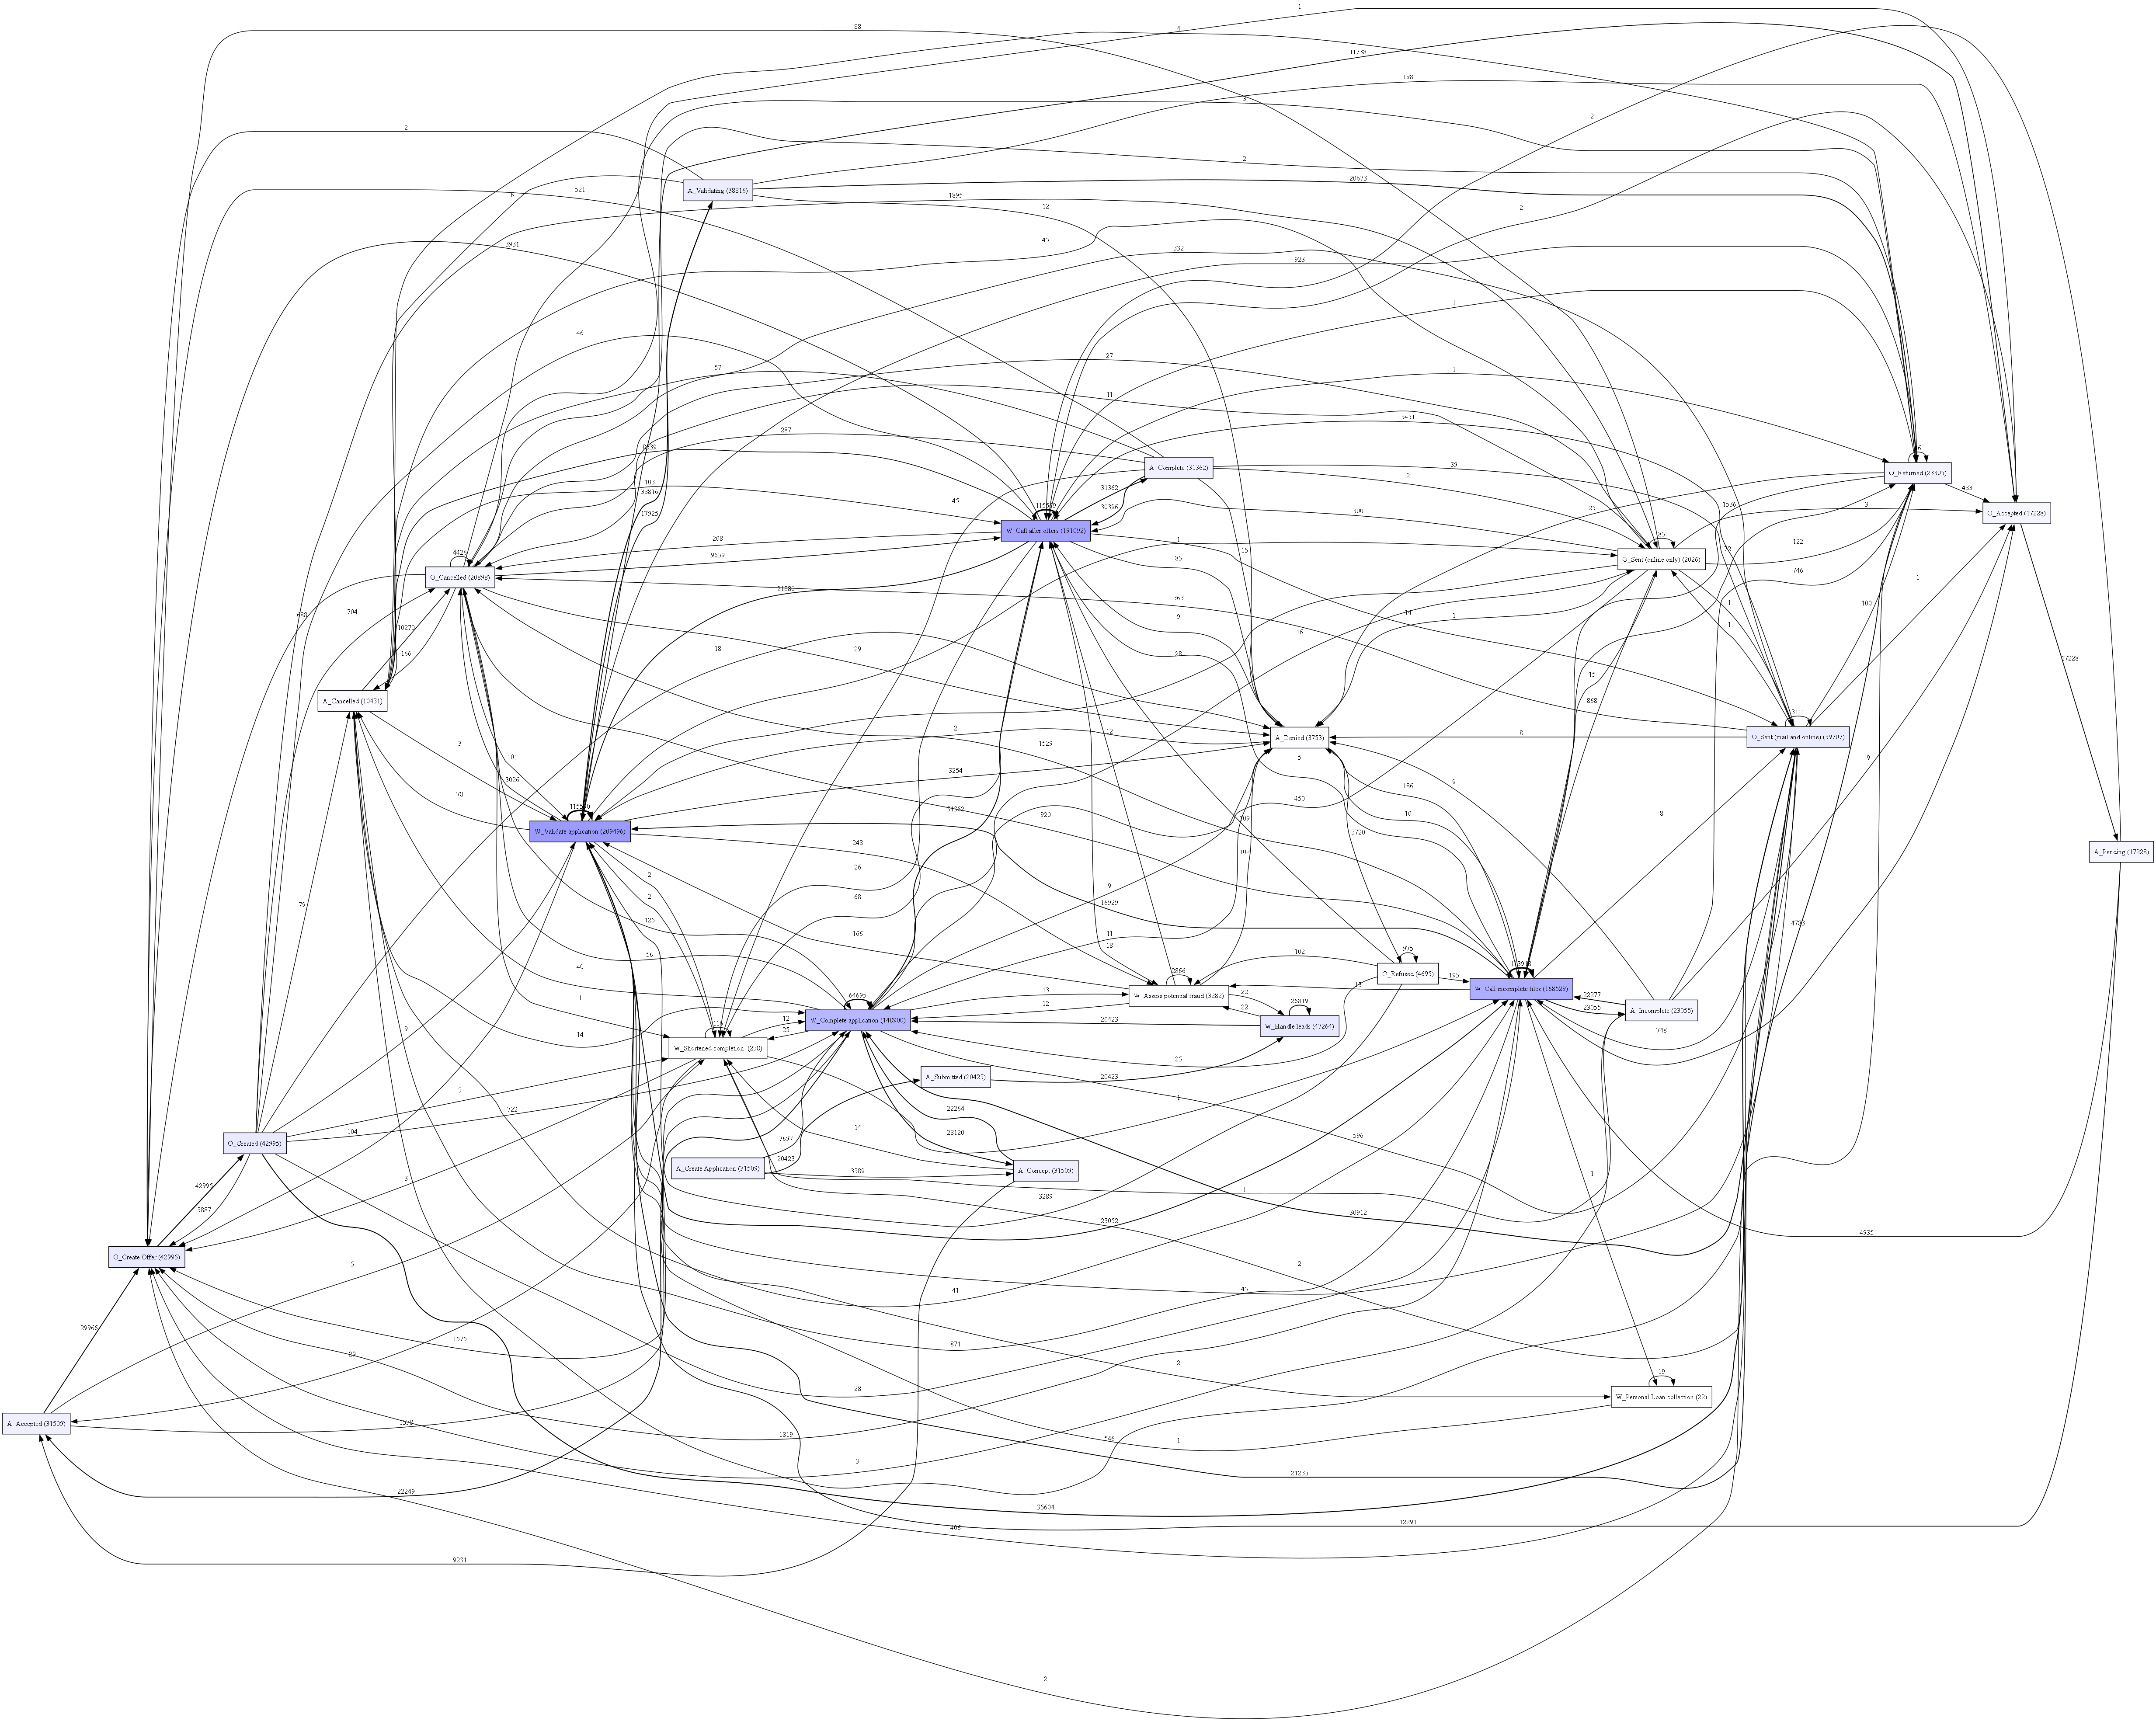

In [4]:
# Visualize the DFG
dfg = dfg_discovery.apply(log)
gviz = dfg_visualizer.apply(dfg, log=log, variant=dfg_visualizer.Variants.FREQUENCY)
dfg_visualizer.view(gviz)

### Instantiating a LogView object ###
The LogViewBuilder class allows instantiating a LogView object, which serves as the central interface for creating LogView instances. It provides a single point of access for interacting with the different framework components.

In [5]:
# Build LogView
log_view = LogViewBuilder.build_log_view(log)

### Evaluate Queries ###


In **LogView**, a `Query` is an object that defines **which cases to include** in your analysis by applying **one or more predicates** (conditions).

Each `Query` filters **entire cases** (i.e., process instances), not individual events.  
This means: If **any single event** in a case meets the condition, the **whole case** is included.

Queries are built on top of **PM4Py**, but provide a higher-level, more expressive interface for filtering event logs, especially when evaluating sequences of filters or tracking case behavior over time.


### How It Works

- A `Query` is initialized using one or more **predicates**, like `EqToConstant`, `GreaterThanConstant`, etc.
- These predicates scan the event log **event by event**, but return results **case by case**.
- When you evaluate a query using:

```python
log_view.evaluate_query('query_name', input_log, query_object)

LogView searches for cases that contain at least one event where the predicate is true, and returns a filtered log of those cases.


### Supported Query Predicates

The following predicates are supported by LogView for constructing filtering queries. These allow you to retrieve cases from the log based on attribute values, control-flow patterns, or logical combinations of filters.

#### Attribute-Based Predicates

These predicates operate on event attributes (e.g., `amount`, `resource`, etc.):

- **`EqToConstant(attribute, value)`**  
  Keeps cases that contain at least one event where `attribute == value`.

- **`NotEqToConstant(attribute, value)`**  
  Keeps cases that do **not** contain any event where `attribute == value`.

- **`GreaterEqualToConstant(attribute, value)`**  
  Keeps cases with at least one event where `attribute >= value`.

- **`GreaterThanConstant(attribute, value)`**  
  Keeps cases with at least one event where `attribute > value`.

- **`LessEqualToConstant(attribute, value)`**  
  Keeps cases with at least one event where `attribute <= value`.

- **`LessThanConstant(attribute, value)`**  
  Keeps cases with at least one event where `attribute < value`.

#### Control-Flow Predicates

These predicates focus on activity sequences:

- **`StartWith(['Activity1', 'Activity2', ...])`**  
  Keeps cases that **start with** any of the listed activities.

- **`EndWith(['Activity1', 'Activity2', ...])`**  
  Keeps cases that **end with** any of the listed activities.

- **`DurationWithin(min_seconds, max_seconds)`**  
  Keeps cases where the **total duration** is within the given range (in seconds).

#### Logical Composition

- **`Union(predicate1, predicate2, ...)`**  
  Represents a **logical OR** between multiple predicates. Cases satisfying **any** of the predicates are retained.


#### Examples

```python
EndWith(['Send Fine', 'Appeal to Judge'])
LessEqualToConstant('amount', 100)
Union(
    EndWith(['Send Fine']),
    LessThanConstant('amount', 250)
)

In [6]:
# CreditScore ≥ 600
query_1 = Query('GoodCredit', [GreaterEqualToConstant('CreditScore', 600)])
result_set_1, complement_1 = log_view.evaluate_query('rs_GoodCredit', log, query_1)

# RequestedAmount ≥ 10000
query_2 = Query('LoanOverThreshold', [GreaterEqualToConstant('RequestedAmount', 10000)])
result_set_2, complement_2 = log_view.evaluate_query('rs_LoanOverThreshold', result_set_1, query_2)

# RequestedAmount < 15000
query_3 = Query('SmallAmount', [LessThanConstant('RequestedAmount', 15000)])
result_set_3, complement_3 = log_view.evaluate_query('rs_SmallAmount', result_set_2, query_3)

# ApplicationType = 'New credit'
query_4 = Query('IsNewCredit', [EqToConstant('ApplicationType', 'New credit')])
result_set_4, complement_4 = log_view.evaluate_query('rs_IsNewCredit', result_set_3, query_4)

In [7]:
# It is possible to start another analysis on the source log, this wil also be added to the same LogView object, but can be used seperately later on:

# Starts with A_Create Application
query_5 = Query('StartWithCreate', [StartWith(['A_Create Application'])])
result_set_5, complement_5 = log_view.evaluate_query('rs_StartWithCreate', log, query_5)

# Duration between 2 and 7 days
query_6 = Query('ModerateDuration', [DurationWithin(172800, 604800)])
result_set_6, complement_6 = log_view.evaluate_query('rs_ModerateDuration', result_set_5, query_6)

### General Form ##

```python
query_name = Query('QueryLabel', [ConditionFunction(field, value)])
result_set, complement = log_view.evaluate_query('ResultSetName', input_log, query_name)


In [8]:
# Practice writing your own Query:


### The LogView Registry

The **Registry** is the central memory of LogView. It automatically tracks every filtering action you perform during analysis, including the **query**, **source log**, and **result set**.  
Each time you call `log_view.evaluate_query(...)`, a new entry is added to this registry.

### What Does the Registry Store?

For each query evaluation, LogView stores:

- **Source log**: The log the query was applied to
- **Query object**: The actual query and predicates used
- **Resulting log**: The set of cases that matched
- **Parent-child relationship**: Tracing how result sets are derived

This creates a full **lineage** of your filtering steps, including all queries and their results.

### How to View the Registry Summary

You can retrieve a full summary of your analysis history:

```python
summary = log_view.get_summary()

In [9]:
summary = log_view.get_summary()

+----+----------------------+-------------------+----------------------+----------+
|    | source_log           | query             | result_set           | labels   |
|----+----------------------+-------------------+----------------------+----------|
|  0 | initial_source_log   | GoodCredit        | rs_GoodCredit        | []       |
|  1 | rs_GoodCredit        | LoanOverThreshold | rs_LoanOverThreshold | []       |
|  2 | rs_LoanOverThreshold | SmallAmount       | rs_SmallAmount       | []       |
|  3 | rs_SmallAmount       | IsNewCredit       | rs_IsNewCredit       | []       |
|  4 | initial_source_log   | StartWithCreate   | rs_StartWithCreate   | []       |
|  5 | rs_StartWithCreate   | ModerateDuration  | rs_ModerateDuration  | []       |
+----+----------------------+-------------------+----------------------+----------+
+----+-------------------+----------------------------------------+
|    | query             | predicates                             |
|----+------------------

### The `icicle()` Function ###

The `icicle()` function visualizes how a specific result set was derived from a sequence of filters applied to the event log. It builds an **icicle chart** that shows the hierarchical filtering steps and metrics for each resulting subset.

Function Signature:
```python
icicle(result_set_name, log_view, metric="avg_case_duration_seconds", show_time=False, details=True)

### `icicle()` Function Parameters

| Parameter         | Type      | Description                                                                                                                                                                  |
|------------------|-----------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `result_set_name`| `str`     | The name of the result set you want to visualize. This must match the name used when calling `log_view.evaluate_query(...)`. Any name in the list of "result_set" names can be used to call the function. |
| `log_view`       | `LogView` | A `LogView` object that stores the original event log along with all filtering steps applied. Created using `LogViewBuilder.build_log_view(log)`.                           |
| `metric`         | `str`     | The metric to visualize in the chart. Supported options:<br> • `"avg_case_duration_seconds"` (default)<br> • `"avg_events_per_case"`<br> • `"avg_time_between_events"`      |
| `show_time`      | `bool`    | If `True`, prints the time taken for each internal step (lineage extraction, filtering, plotting). Default is `False`.                                                      |
| `details`        | `bool`    | If `True` (default), prints a summary showing all filter steps, number of cases per subset, and computed metric values.                                                     |


### How the `icicle(...)` Chart Is Built

1. **Retrieve the query history (lineage)**  
   When you pass a result set name (e.g. `'rs_HighValue'`) to the `icicle(...)` function, it first looks up how that result set was created — including all the queries applied in order. This is called the *lineage*, and it includes the original log, each filter step, and the corresponding query names.

2. **Load the initial source log**  
   The chart starts from the original dataset (before any filters). This log is retrieved from the registry as the **initial source log**.

3. **Add case-level metrics**  
   Depending on the metric you're analyzing (`avg_case_duration_seconds`, `avg_events_per_case`, or `avg_time_between_events`), the function adds one of the following columns:
   - Case duration (time from first to last event in the case)
   - Number of events per case
   - Average time between events in each case

4. **Apply each filter in sequence**  
   For every query in the lineage, the log is split into two subsets:
   - ✓ One where cases **pass** the filter
   - ✗ One where cases **fail** the filter  
   Each new subset is labeled and tracked with a growing path of decisions — which forms the basis of the final tree.

5. **Track the "main path"**  
   The path that includes only passing filters (i.e. the result set you're analyzing) is marked in the chart with yellow dots (🟡) to help you identify it.

6. **Aggregate case metrics**  
   For every subset (leaf node in the tree), the chart computes:
   - The number of unique cases
   - The average value for the selected metric (e.g., average case duration)

7. **Build the visualization**  
   All labeled subsets are passed to Plotly’s `icicle` chart function. Each box in the chart:
   - Represents a decision step (filter pass/fail)
   - Shows how many cases followed that path
   - Is color-coded by the chosen metric for easy comparison


Intended Use:
- Get a visual understanding of how filters affect your dataset.
- Identify which branches of the filtering tree are interesting or potentially problematic.
- Validate your filtering logic and observe how metrics change across subsets.
- Clearly communicate your data preparation and filtering steps.

The icicle chart highlights the **main filtering path** (the sequence of subsets that passed each filter step) with **yellow dots 🟡**.  
When you **click on a subset** in the chart, it zooms in to show a more detailed view, allowing for easier comparison between branches.

In [10]:
# Example 1
icicle('rs_IsNewCredit', log_view, metric='avg_case_duration_seconds', details=False)

In [11]:
# Example 2
icicle('rs_SmallAmount', log_view, metric='avg_events_per_case', details=False)

In [12]:
# Example 3: details=True
icicle('rs_LoanOverThreshold', log_view, metric='avg_time_between_events', details=True)


Summary with Metrics:

- 🟡 10,084 cases (Initial Source → (CreditScore >= 600) ✅ → (RequestedAmount >= 10000) ✅) | Avg Time Between Events (s): 10h 21m
- 5,154 cases (Initial Source → (CreditScore >= 600) ✅ → (RequestedAmount >= 10000) ❌) | Avg Time Between Events (s): 9h 28m
- 10,020 cases (Initial Source → (CreditScore >= 600) ❌ → (RequestedAmount >= 10000) ✅) | Avg Time Between Events (s): 23h 7m
- 6,251 cases (Initial Source → (CreditScore >= 600) ❌ → (RequestedAmount >= 10000) ❌) | Avg Time Between Events (s): 23h 22m


### General Form of the `icicle()` Function: ###

```python
icicle(result_set_name, log_view, metric='metric_name', details=False)


In [13]:
# Call the icicle() function on your own previously created Query:


### The `pie()` Function ###

The `pie()` function is designed to provide **contextual insight** into a specific filter step applied to a result set.

More precisely, it answers the question:

> *"For a given filter that resulted in a certain subset (`result_set_name`), where else in the event log does this same filter also evaluate to true?"*

This allows you to assess:

- **Representativeness:** Does the number of cases that passed the filter in this specific result set accurately reflect the broader event log? Or were important cases filtered out earlier in the pipeline?
- **Metric divergence:** The chart colors encode metric values (e.g. average case duration). This highlights whether the same filter selects **similar** cases in terms of process behavior across different branches, or whether those cases **behave differently**.

Each slice in the pie chart represents a group of cases where the filter condition is met, segmented by their historical lineage (i.e., the filter path leading to them). When **hovering** over the slices, the full fitlering path shows.

Function Signature
```python
pie(result_set_name, log_view, metric="avg_case_duration_seconds", details=True)

### `pie()` Function Parameters

| Parameter         | Type      | Description |
|------------------|-----------|-------------|
| `result_set_name`| `str`     | The name of the result set you want to visualize. This must correspond to a result set created via `log_view.evaluate_query(...)`. |
| `log_view`       | `LogView` | The `LogView` object containing the original event log and all registered filtering steps. |
| `metric`         | `str`     | The metric to visualize across the subsets. Supported values:<br> • `"avg_case_duration_seconds"` (default)<br> • `"avg_events_per_case"`<br> • `"avg_time_between_events"` |
| `details`        | `bool`    | If `True` (default), prints a summary listing all filter paths with number of cases and the average metric per path. |


### How the `pie(...)` Chart Is Built

1. **Identify the last filter step**  
   The function begins by retrieving the query that produced the selected result set (e.g. `'rs_Successful'`). This includes the query expression, source log, and any earlier filtering steps.

2. **Locate sibling subsets**  
   LogView splits the log into two subsets at each query:
   - ✓ Cases that pass the filter (i.e. the selected result set)
   - ✗ Cases that fail the same filter  
   The `pie(...)` chart focuses on comparing these two **siblings**, showing how the final filter divided the data.

3. **Add case-level metrics**  
   Depending on the chosen metric:
   - `avg_case_duration_seconds` → adds case durations
   - `avg_events_per_case` → adds event counts per case
   - `avg_time_between_events` → computes average time gaps between events  
   These metrics are added as new columns to the log for analysis.

4. **Trace case paths**  
   For every case in the filtered log, the function reconstructs its full filter path (e.g. `RequestedAmount > 10000 ✅ → ApplicationType = 'New' ✅ → EndWith('A_Pending') ✅`).  
   These paths are stored as strings and used as labels for the pie slices.

5. **Aggregate statistics**  
   For each unique path:
   - Count the number of cases
   - Calculate the average value of the selected metric (duration, count, or time gap)

6. **Create the pie chart**  
   The chart shows:
   - Slice size = number of cases for that path
   - Color = average value of the selected metric  
   The slice corresponding to the final result set is marked with a yellow dot (🟡) for clarity.

7. **Add color bar and hover labels**  
   A color scale is added for interpretation (e.g. average case duration), and hovering on a slice reveals the full filter path and metric value.


This chart is useful for understanding the **impact of the final query**, by comparing passed vs. failed cases and revealing differences in behavior across filtered subsets.


In [14]:
# Example 4
pie('rs_IsNewCredit', log_view, metric='avg_case_duration_seconds', details=False)

In [15]:
# Example 5
pie('rs_SmallAmount', log_view, metric='avg_events_per_case', details=False)

In [16]:
# Example 6: details=True
pie('rs_LoanOverThreshold', log_view, metric='avg_time_between_events', details=True)


Filter Paths:

- 🟡 10,084 cases (50%): (CreditScore >= 600) ✅ → (RequestedAmount >= 10000) ✅ | Avg Time Between Events (s): 10h 10m
- 10,020 cases (50%): (CreditScore >= 600) ❌ → (RequestedAmount >= 10000) ✅ | Avg Time Between Events (s): 20h 11m


### General Form of the `pie()` Function: ###

```python
pie(result_set_name, log_view, metric='metric_name', details=False)


In [17]:
# Try calling the 'pie()' function on your own Query:
